<a href="https://colab.research.google.com/github/Emmyspecialg/BigData/blob/main/thesizingproblem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Sizing Problem

* Layer 1 — Body representation model (brand-agnostic)
* Layer 2 — Brand-specific size mapping (rule-based or learned)


https://www.kaggle.com/datasets/saurabhshahane/body-measurements-dataset/data)

## Layer 1 : Brand-Agnostic Body Representation (Body Profiles)

> Who are you physically?

Layer 1 is critical because it separates body shape modeling from brand-specific sizing rules, allowing the system to learn true human body structure without being biased by any retailer’s size definitions. By creating a gender-aware, brand-agnostic, probabilistic representation of body archetypes, Layer 1 provides a stable foundation that can be reused across different clothing brands, each of which applies its own sizing logic to the same underlying body geometry. This decoupling makes it possible to explain why the same person may be assigned different sizes across brands (e.g., Zara vs. GAP) while preserving uncertainty for individuals who fall between sizes, something that would not be achievable if size labels were modeled directly.


In Layer 1 of this project, we model human body shape using Principal Component Analysis (PCA) and a Gaussian Mixture Model (GMM) to create a brand-agnostic representation of body geometry. Raw body measurements are high-dimensional, highly correlated, and noisy; many measurements scale together and obscure the underlying structure of body shape. PCA is therefore used to transform the original measurements and derived proportional ratios into a compact, orthogonal feature space that captures the dominant modes of body variation (such as overall scale, upper-to-lower body balance, and vertical proportions) while reducing redundancy and improving numerical stability. This dimensionality reduction is especially important for mixture models, as it enables robust covariance estimation and prevents overfitting.

A Gaussian Mixture Model is then applied to the PCA-transformed features to learn latent body archetypes without relying on predefined clothing size labels. GMMs are well-suited for this task because human body shapes do not form hard, discrete categories; instead, they exist on a continuum. Unlike hard clustering methods, GMMs provide soft probabilistic assignments, allowing each individual to belong to multiple body archetypes with varying confidence. This probabilistic representation captures real-world ambiguity—such as individuals who fall between traditional sizes—and preserves uncertainty that is critical for downstream sizing decisions. The output of Layer 1 is therefore not a size prediction, but a stable, gender-specific, brand-agnostic body embedding that can later be mapped to different retailers’ sizing systems in Layer 2.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('Body Measurements _ original_CSV.csv')

# Strip leading/trailing whitespace from column names
df.columns = df.columns.str.strip()

df.head(5)
#df.columns


,Gender,Age,HeadCircumference,ShoulderWidth,ChestWidth,Belly,Waist,Hips,ArmLength,ShoulderToWaist,WaistToKnee,LegLength,TotalHeight
0,1.0,30,22,18,20,18,14,22,22,25,25,22,52
1,1.0,28,19,22,17,18,21,25,28,23,25,20,56
2,2.0,27,21,18,16,14,10,15,21,18,14,18,53
3,1.0,29,20,20,18,11,19,14,24,21,20,21,45
4,2.0,28,16,14,18,13,11,30,25,22,32,13,47


# MALE ONLY PCA AND GMM

In [46]:
import pandas as pd
import numpy as np

df_male = df[df["Gender"] == 1].copy()


In [47]:
base_features = [
    "ShoulderWidth",
    "ChestWidth",
    "Waist",
    "Hips",
    "LegLength",
    "ShoulderToWaist",
    "TotalHeight",
]

X_male = df_male[base_features].copy()

# Basic sanity filtering
X_male = X_male.dropna()
X_male = X_male[(X_male["Waist"] > 0) & (X_male["TotalHeight"] > 0)]


In [48]:
X_male["hip_waist_ratio"] = X_male["Hips"] / X_male["Waist"]
X_male["bust_waist_ratio"] = X_male["ChestWidth"] / X_male["Waist"]
X_male["shoulder_hip_ratio"] = X_male["ShoulderWidth"] / X_male["Hips"]
X_male["leg_height_ratio"] = X_male["LegLength"] / X_male["TotalHeight"]
X_male["torso_height_ratio"] = X_male["ShoulderToWaist"] / X_male["TotalHeight"]


In [49]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_male_scaled = scaler.fit_transform(X_male)


In [104]:
# from sklearn.mixture import GaussianMixture
# from sklearn.decomposition import PCA

# results = []

# pca_range = range(3, 9)      # test PCA dims
# cluster_range = range(2, 8)  # test GMM clusters

# for pca_k in pca_range:
#     pca = PCA(n_components=pca_k, random_state=42)
#     X_pca = pca.fit_transform(X_male_scaled)

#     for gmm_k in cluster_range:
#         gmm = GaussianMixture(
#             n_components=gmm_k,
#             covariance_type="full",
#             random_state=42
#         )
#         gmm.fit(X_pca)

#         results.append({
#             "pca_components": pca_k,
#             "gmm_clusters": gmm_k,
#             "BIC": gmm.bic(X_pca),
#             "explained_variance": pca.explained_variance_ratio_.sum()
#         })

# import pandas as pd
# results_df = pd.DataFrame(results)

# results_df.sort_values("BIC").head(10)


In [101]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5 , random_state=42) # 5, changeable, supportive with BIC/AIC
X_male_pca = pca.fit_transform(X_male_scaled)

print("Explained variance:", pca.explained_variance_ratio_)


Explained variance: [0.32352915 0.17371319 0.15416067 0.13814203 0.08746683]


In [102]:
from sklearn.mixture import GaussianMixture

bic_scores = []
aic_scores = []
cluster_range = range(2, 8)  # typical for males

for k in cluster_range:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type="full",
        random_state=42
    )
    gmm.fit(X_male_pca)

    bic_scores.append(gmm.bic(X_male_pca))
    aic_scores.append(gmm.aic(X_male_pca))

bic_male_df = pd.DataFrame({
    "n_clusters": cluster_range,
    "BIC": bic_scores,
    "AIC": aic_scores
})

bic_male_df


,n_clusters,BIC,AIC
0,2,6736.411459,6573.694449
1,3,6680.051086,6433.991217
2,4,6622.171220,6292.768493
3,5,6553.662995,6140.917409
4,6,6564.806382,6068.717937
5,7,6516.512440,5937.081136


In [103]:
BEST_K = 5  #5 ← replace with BIC winner

gmm_male = GaussianMixture(
    n_components=BEST_K,
    covariance_type="full",
    random_state=42
)

gmm_male.fit(X_male_pca)

male_cluster_probs = gmm_male.predict_proba(X_male_pca)
male_cluster_labels = gmm_male.predict(X_male_pca)


In [105]:
#A ttach results back to MALE dataframe
male_result = df_male.loc[X_male.index].copy()

for i in range(male_cluster_probs.shape[1]):
    male_result[f"male_body_cluster_prob_{i}"] = male_cluster_probs[:, i]

male_result["male_body_cluster"] = male_cluster_labels


In [106]:
#Sanity Check

male_result.filter(like="male_body_cluster_prob").sum(axis=1).head()


,0
0,1.0
1,1.0
3,1.0
8,1.0
9,1.0


In [107]:
prob_cols = [f"male_body_cluster_prob_{i}" for i in range(BEST_K)]

male_result["active_body_cluster"] = (
    male_result[prob_cols]
    .idxmax(axis=1)
    .str.replace("male_body_cluster_prob_", "")
    .astype(int)
)


In [108]:
male_result.head(1)


,Gender,Age,HeadCircumference,ShoulderWidth,ChestWidth,Belly,Waist,Hips,ArmLength,ShoulderToWaist,WaistToKnee,LegLength,TotalHeight,male_body_cluster_prob_0,male_body_cluster_prob_1,male_body_cluster_prob_2,male_body_cluster_prob_3,male_body_cluster_prob_4,male_body_cluster,active_body_cluster
0,1.0,30,22,18,20,18,14,22,22,25,25,22,52,4.784449e-07,7.423038e-15,7.622597e-259,1.0,2.417839e-12,3,3


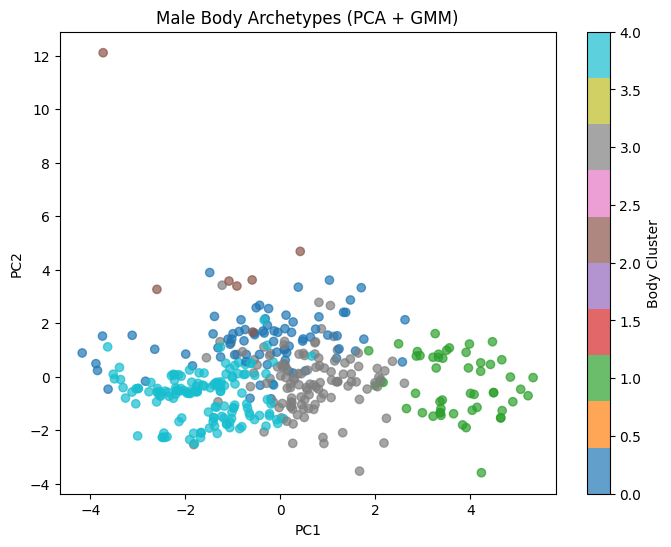

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(
    X_male_pca[:, 0],  # PC1
    X_male_pca[:, 1],  # PC2
    c=male_result["active_body_cluster"],
    cmap="tab10",
    alpha=0.7
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Male Body Archetypes (PCA + GMM)")
plt.colorbar(label="Body Cluster")
plt.show()



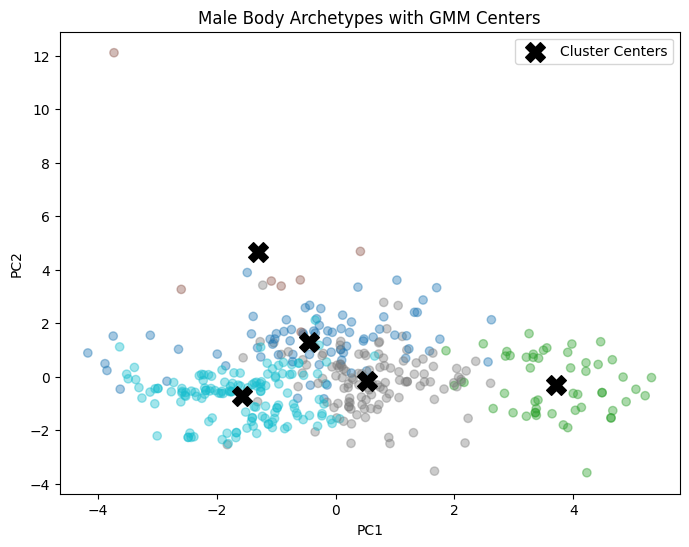

In [110]:
# GMM cluster centers in PCA space --
centers = gmm_male.means_

plt.figure(figsize=(8, 6))
plt.scatter(
    X_male_pca[:, 0],
    X_male_pca[:, 1],
    c=male_result["active_body_cluster"],
    cmap="tab10",
    alpha=0.4
)

plt.scatter(
    centers[:, 0],
    centers[:, 1],
    c="black",
    s=200,
    marker="X",
    label="Cluster Centers"
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Male Body Archetypes with GMM Centers")
plt.legend()
plt.show()


> This figure shows the PCA projection of male body measurements, where each point represents an individual and colors indicate the dominant body archetype learned by a Gaussian Mixture Model. The black “X” markers denote the Gaussian component means, representing prototypical body shapes within each archetype. Overlap between clusters reflects the continuous nature of human body variation and enables probabilistic reasoning for individuals who fall between traditional sizing categories.


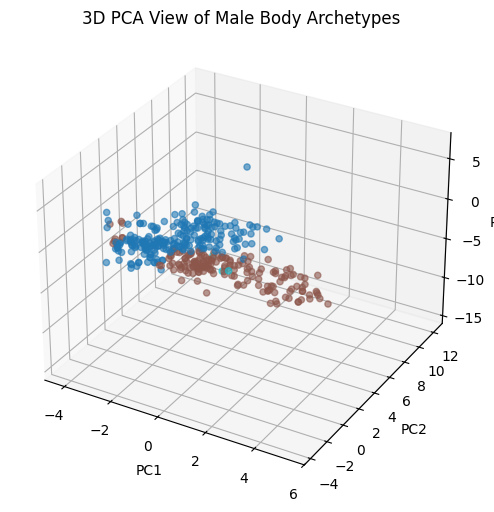

In [99]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    X_male_pca[:, 0],
    X_male_pca[:, 1],
    X_male_pca[:, 2],
    c=male_result["active_body_cluster"],
    cmap="tab10",
    alpha=0.6
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA View of Male Body Archetypes")

plt.show()


In [112]:
male_result["max_prob"] = male_result.filter(
    like="male_body_cluster_prob"
).max(axis=1)

male_result["max_prob"].describe()


,max_prob
count,391.000000
mean,0.941910
std,0.110098
min,0.492170
25%,0.957065
50%,0.994814
75%,0.999676
max,1.000000


In [113]:
male_result.head(10)

,Gender,Age,HeadCircumference,ShoulderWidth,ChestWidth,Belly,Waist,Hips,ArmLength,ShoulderToWaist,...,LegLength,TotalHeight,male_body_cluster_prob_0,male_body_cluster_prob_1,male_body_cluster_prob_2,male_body_cluster_prob_3,male_body_cluster_prob_4,male_body_cluster,active_body_cluster,max_prob
0,1.0,30,22,18,20,18,14,22,22,25,...,22,52,4.784449e-07,7.423038e-15,7.622597e-259,1.000000,2.417839e-12,3,3,1.000000
1,1.0,28,19,22,17,18,21,25,28,23,...,20,56,2.402565e-08,2.032024e-09,0.000000e+00,1.000000,3.153693e-15,3,3,1.000000
3,1.0,29,20,20,18,11,19,14,24,21,...,21,45,1.028950e-02,7.741683e-11,3.217375e-179,0.989706,4.123662e-06,3,3,0.989706
8,1.0,23,16,16,20,18,22,18,15,26,...,19,40,8.803433e-06,5.469024e-18,1.168210e-207,0.999991,1.166946e-10,3,3,0.999991
9,1.0,31,15,20,28,18,91,17,16,21,...,19,55,2.892679e-18,9.952087e-01,0.000000e+00,0.004791,1.531891e-31,1,1,0.995209
10,1.0,29,16,28,17,15,21,30,17,25,...,17,50,1.112868e-09,1.200931e-09,0.000000e+00,1.000000,3.140724e-23,3,3,1.000000
11,1.0,35,23,21,18,12,18,27,18,17,...,20,49,2.590813e-08,9.188796e-15,2.424596e-243,1.000000,5.794865e-11,3,3,1.000000
13,1.0,30,19,17,18,18,24,28,23,22,...,24,47,8.819124e-07,2.885668e-10,5.369224e-233,0.999997,2.285516e-06,3,3,0.999997
17,1.0,30,21,18,21,12,19,21,15,20,...,20,59,4.105685e-09,4.598117e-14,6.604305e-303,1.000000,6.107019e-16,3,3,1.000000
18,1.0,35,20,16,28,18,17,23,16,27,...,9,48,4.296146e-16,6.672209e-42,0.000000e+00,1.000000,3.953078e-43,3,3,1.000000


# FEMALE ONLY PCA AND GMM

In [67]:
import pandas as pd
import numpy as np

df_female = df[df["Gender"] == 2].copy()

In [68]:
base_features = [
    "ShoulderWidth",
    "ChestWidth",
    "Waist",
    "Hips",
    "LegLength",
    "ShoulderToWaist",
    "TotalHeight",
]

X_female = df_female[base_features].copy()

# Basic sanity filtering
X_female = X_female.dropna()
X_female = X_female[(X_female["Waist"] > 0) & (X_female["TotalHeight"] > 0)]

In [69]:
X_female["hip_waist_ratio"] = X_female["Hips"] / X_female["Waist"]
X_female["bust_waist_ratio"] = X_female["ChestWidth"] / X_female["Waist"]
X_female["shoulder_hip_ratio"] = X_female["ShoulderWidth"] / X_female["Hips"]
X_female["leg_height_ratio"] = X_female["LegLength"] / X_female["TotalHeight"]
X_female["torso_height_ratio"] = X_female["ShoulderToWaist"] / X_female["TotalHeight"]

In [70]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_female_scaled = scaler.fit_transform(X_female)

In [71]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5, random_state=42) # changeable, supportive with BIC/AIC
X_female_pca = pca.fit_transform(X_female_scaled)

print("Explained variance:", pca.explained_variance_ratio_)

Explained variance: [0.29373081 0.19078638 0.14231847 0.12322738 0.11198674]


In [73]:
from sklearn.mixture import GaussianMixture

bic_scores = []
aic_scores = []
cluster_range = range(2, 9)  # typical for males

for k in cluster_range:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type="full",
        random_state=42
    )
    gmm.fit(X_female_pca)

    bic_scores.append(gmm.bic(X_female_pca))
    aic_scores.append(gmm.aic(X_female_pca))

bic_female_df = pd.DataFrame({
    "n_clusters": cluster_range,
    "BIC": bic_scores,
    "AIC": aic_scores
})

bic_female_df

,n_clusters,BIC,AIC
0,2,5469.377581,5314.367096
1,3,5631.173302,5396.767204
2,4,5305.257176,4991.455465
3,5,5315.174468,4921.977142
4,6,5278.753392,4806.160453
5,7,5227.675291,4675.686738
6,8,5372.840692,4741.456525


In [74]:
BEST_K = 7  # ← replace with BIC winner

gmm_female = GaussianMixture(
    n_components=BEST_K,
    covariance_type="full",
    random_state=42
)

gmm_female.fit(X_female_pca)

female_cluster_probs = gmm_female.predict_proba(X_female_pca)
female_cluster_labels = gmm_female.predict(X_female_pca)


In [75]:
#A ttach results back to female dataframe
female_result = df_female.loc[X_female.index].copy()

for i in range(female_cluster_probs.shape[1]):
    female_result[f"female_body_cluster_prob_{i}"] = female_cluster_probs[:, i]

female_result["female_body_cluster"] = female_cluster_labels

In [76]:
#Sanity Check

female_result.filter(like="female_body_cluster_prob").sum(axis=1).head()

,0
2,1.0
4,1.0
5,1.0
6,1.0
7,1.0


In [79]:
prob_cols = [f"female_body_cluster_prob_{i}" for i in range(BEST_K)]

female_result["active_body_cluster"] = (
    female_result[prob_cols]
    .idxmax(axis=1)
    .str.replace("female_body_cluster_prob_", "")
    .astype(int)
)

In [80]:
female_result.head(1)

,Gender,Age,HeadCircumference,ShoulderWidth,ChestWidth,Belly,Waist,Hips,ArmLength,ShoulderToWaist,...,TotalHeight,female_body_cluster_prob_0,female_body_cluster_prob_1,female_body_cluster_prob_2,female_body_cluster_prob_3,female_body_cluster_prob_4,female_body_cluster_prob_5,female_body_cluster_prob_6,female_body_cluster,active_body_cluster
2,2.0,27,21,18,16,14,10,15,21,18,...,53,2.740691e-129,1.868862e-12,1.0,8.132473e-107,7.919716e-18,1.038987e-10,0.0,2,2


In [116]:
X_female_pca.shape

(324, 5)

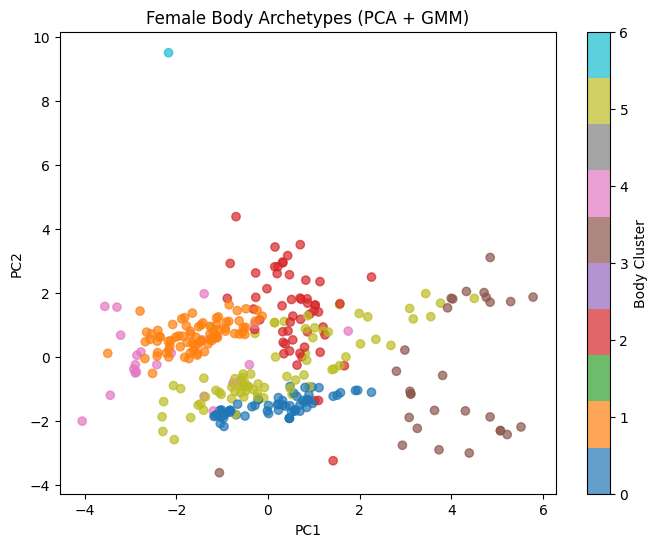

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(
    X_female_pca[:, 0],  # PC1
    X_female_pca[:, 1],  # PC2
    c=female_result["active_body_cluster"],
    cmap="tab10",
    alpha=0.7
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Female Body Archetypes (PCA + GMM)")
plt.colorbar(label="Body Cluster")
plt.show()



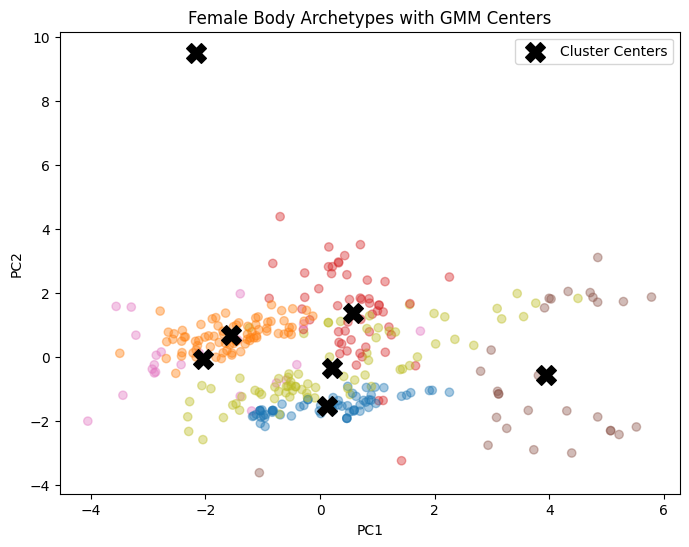

In [83]:
# GMM cluster centers in PCA space --
centers = gmm_female.means_

plt.figure(figsize=(8, 6))
plt.scatter(
    X_female_pca[:, 0],
    X_female_pca[:, 1],
    c=female_result["active_body_cluster"],
    cmap="tab10",
    alpha=0.4
)

plt.scatter(
    centers[:, 0],
    centers[:, 1],
    c="black",
    s=200,
    marker="X",
    label="Cluster Centers"
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Female Body Archetypes with GMM Centers")
plt.legend()
plt.show()

In [84]:
female_result["max_prob"] = female_result.filter(
    like="female_body_cluster_prob"
).max(axis=1)

female_result["max_prob"].describe()

# The results are showing high probability categorization.


,max_prob
count,324.000000
mean,0.954979
std,0.106016
min,0.501023
25%,0.984099
50%,0.998267
75%,0.999938
max,1.000000


 Layer 1 gives us a stable foundation that explains why the same person may wear different sizes at Zara, GAP, or H&M, enabling more accurate size recommendations, fewer returns, and a better customer experience when brand-specific rules are applied later.

## Layer 2

> “Given this body, how does this brand label that body?”